参考B站： https://www.bilibili.com/video/BV1cP4y1V7GF/?spm_id_from=333.788&vd_source=abeb4ad4122e4eff23d97059cf088ab4

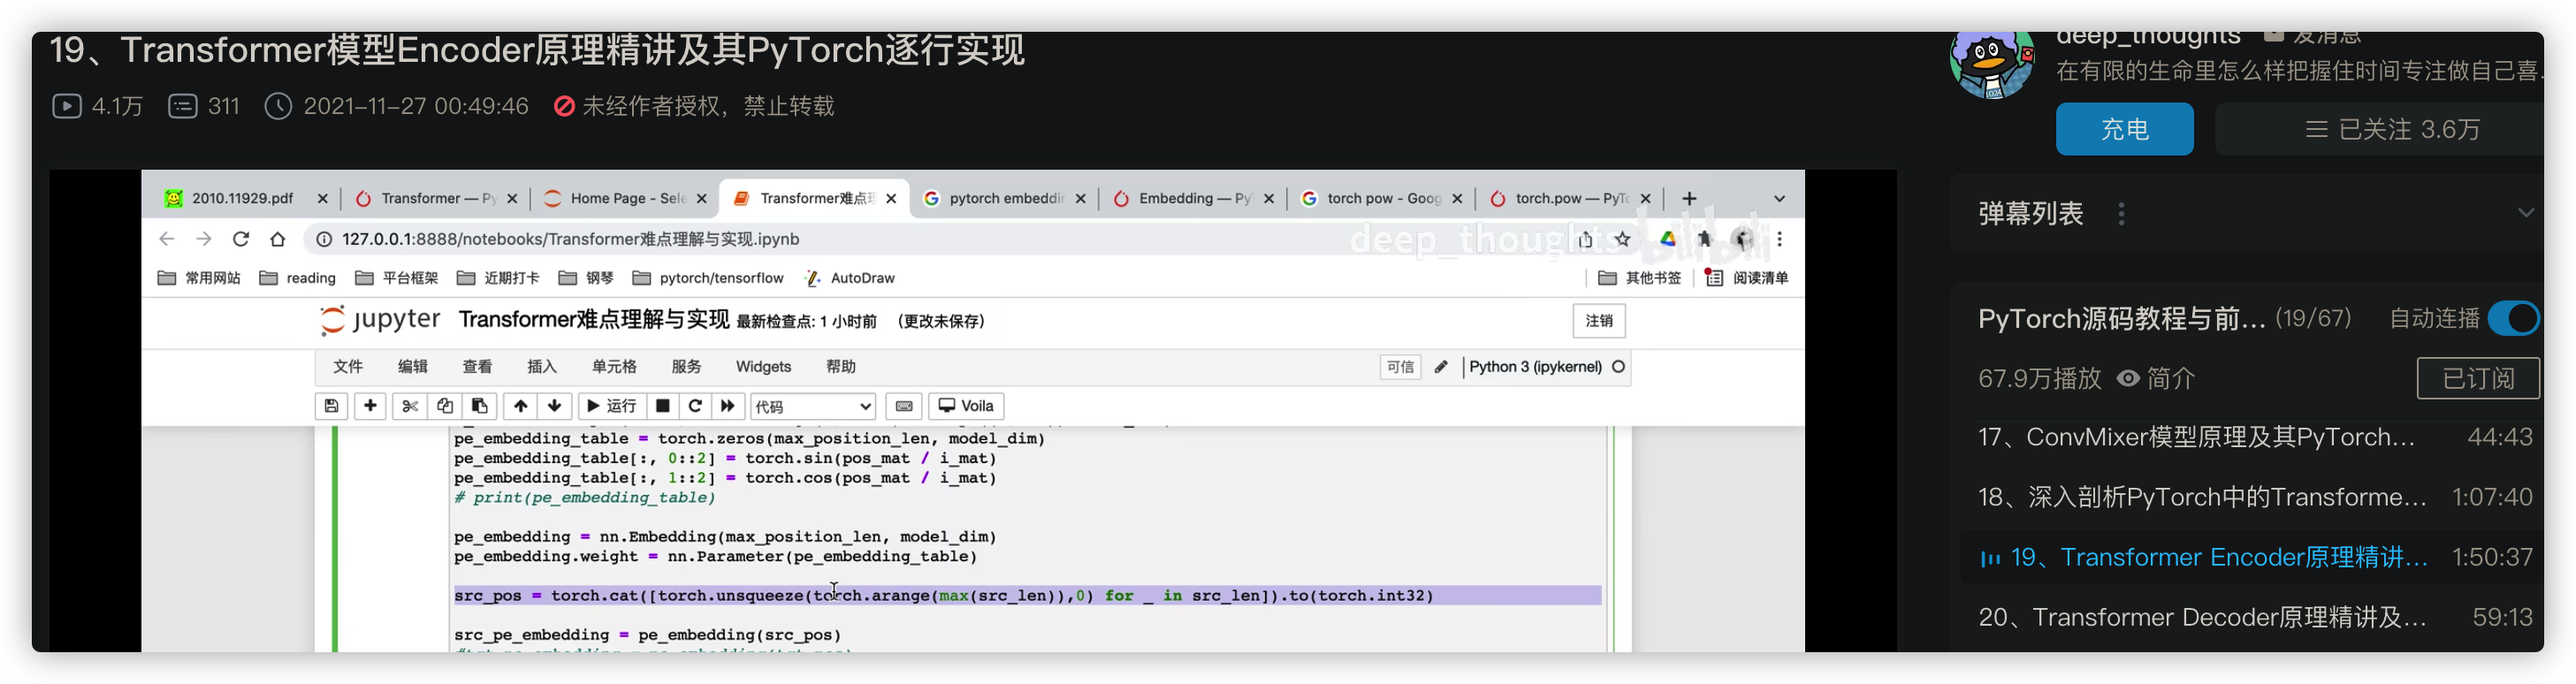

In [2]:
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F


## 1. embedding 构建

### 1.1 word embedding 构建
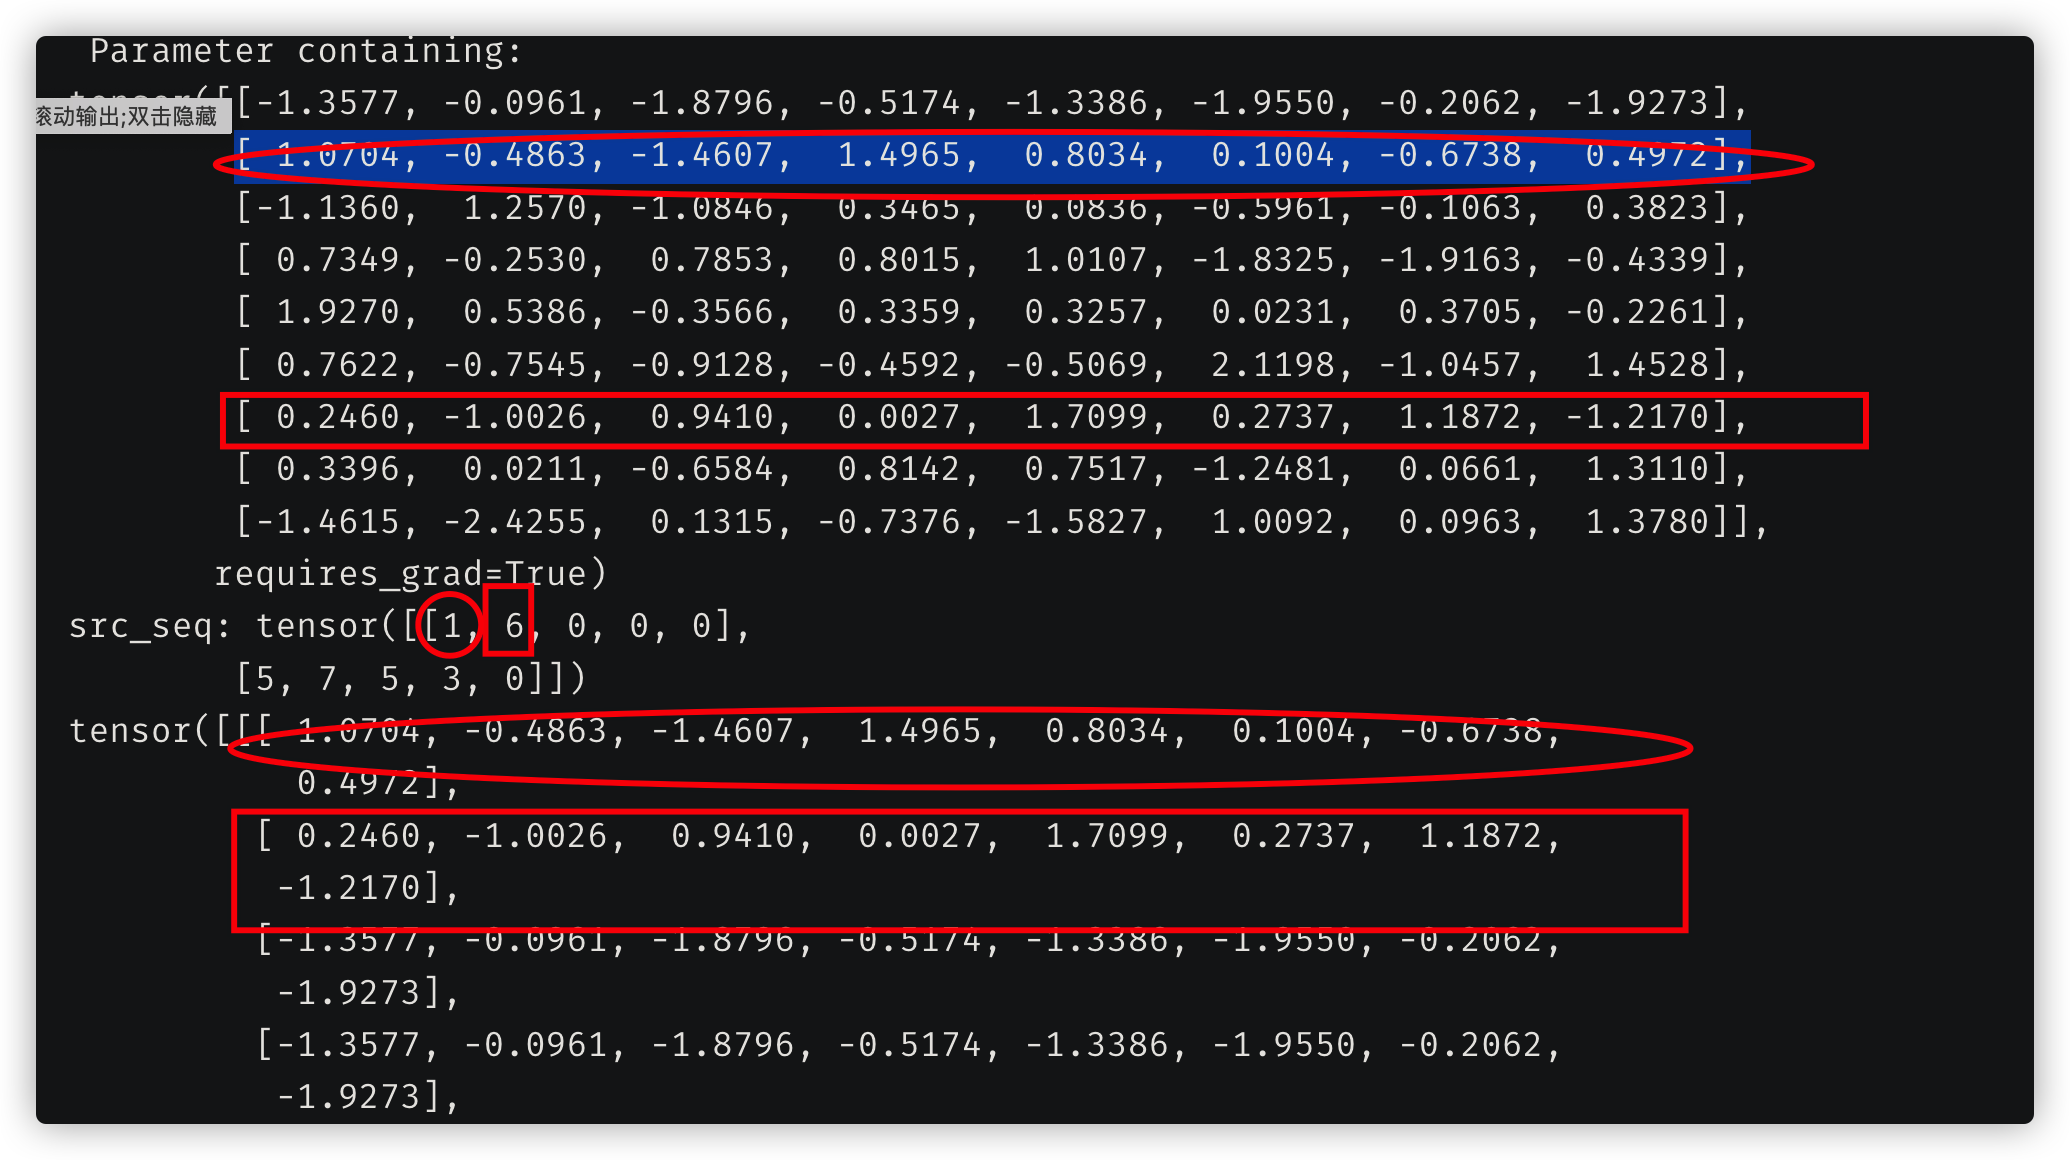

In [55]:
# 以序列建模为例，
# 考虑 source sentence 和 target sentence
batch_size = 2
#单词表大小
max_num_src_words = 8 # (有意义的1,2,3....,8 8个词，0 为pad)
max_num_tar_words = 8
model_dim = 8

# 序列的最大长度，这里参数仅用于生成句子序列
max_src_seq_len = 5
max_tar_seq_len = 5

#  生成输入、目标句子
# # src_len = torch.randint(2, 5, (batch_size,))
# # tar_len = torch.randint(2, 5, (batch_size,))
src_len = torch.tensor([2,4]).to(torch.int32)
print(f'src_len:{src_len}')
tar_len = torch.tensor([4,3]).to(torch.int32)

# 单词索引构成源句子和目标句子, 同时依据最大长度padding，默认值为0
pad_seq = [F.pad(torch.randint(1,max_num_src_words, (l,)), (0, max_src_seq_len-l)) for l in src_len]
print(f'pad 后句子序列：{pad_seq}')
# 再 合并
src_seq = torch.cat([ torch.unsqueeze(i, 0) for i in pad_seq])
tar_seq = torch.cat([torch.unsqueeze(F.pad(torch.randint(1,max_num_tar_words, (l,)), 
                                           (0, max_tar_seq_len-l)), 0) for l in tar_len])
# print(src_seq, '\n', tar_seq)

# 构造 embedding
src_embedding_table = nn.Embedding(max_num_src_words+1, model_dim)
tar_embedding_table = nn.Embedding(max_num_tar_words+1, model_dim)

# 获取输入输出的embedding
src_embedding = src_embedding_table(src_seq)
tar_embedding = tar_embedding_table(tar_seq)

print('embedding 表:\n', src_embedding_table.weight)
print(f'src_seq: {src_seq}')
print(src_embedding)

src_len:tensor([2, 4], dtype=torch.int32)
pad 后句子序列：[tensor([1, 6, 0, 0, 0]), tensor([5, 7, 5, 3, 0])]
embedding 表:
 Parameter containing:
tensor([[-1.3577, -0.0961, -1.8796, -0.5174, -1.3386, -1.9550, -0.2062, -1.9273],
        [ 1.0704, -0.4863, -1.4607,  1.4965,  0.8034,  0.1004, -0.6738,  0.4972],
        [-1.1360,  1.2570, -1.0846,  0.3465,  0.0836, -0.5961, -0.1063,  0.3823],
        [ 0.7349, -0.2530,  0.7853,  0.8015,  1.0107, -1.8325, -1.9163, -0.4339],
        [ 1.9270,  0.5386, -0.3566,  0.3359,  0.3257,  0.0231,  0.3705, -0.2261],
        [ 0.7622, -0.7545, -0.9128, -0.4592, -0.5069,  2.1198, -1.0457,  1.4528],
        [ 0.2460, -1.0026,  0.9410,  0.0027,  1.7099,  0.2737,  1.1872, -1.2170],
        [ 0.3396,  0.0211, -0.6584,  0.8142,  0.7517, -1.2481,  0.0661,  1.3110],
        [-1.4615, -2.4255,  0.1315, -0.7376, -1.5827,  1.0092,  0.0963,  1.3780]],
       requires_grad=True)
src_seq: tensor([[1, 6, 0, 0, 0],
        [5, 7, 5, 3, 0]])
tensor([[[ 1.0704, -0.4863, -1.4607

### 1.2 position embedding 构建
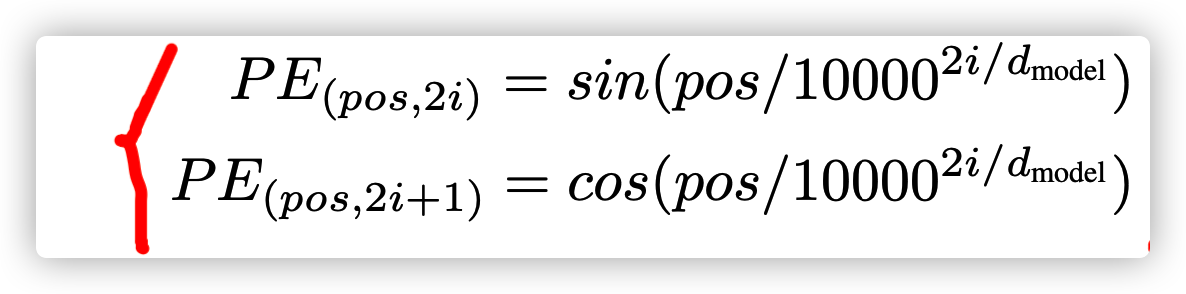

In [44]:
# 广播机制
max_position_len = 5  # 句子最大长度
pos_mat = torch.arange(max_position_len).reshape((-1,1))
i_mat = torch.pow(10000,torch.arange(0,model_dim,2).reshape((1,-1))/model_dim) # 列矩阵
print(pos_mat, '\n',i_mat)
pe_embedding_table = torch.zeros(max_position_len, model_dim)
pe_embedding_table[:, 0::2] = torch.sin(pos_mat/i_mat)  # 偶数列
pe_embedding_table[:, 1::2] = torch.cos(pos_mat/i_mat)  # 奇数列
print(f'{pe_embedding_table}')

pe_embedding = nn.Embedding(max_position_len, model_dim)
pe_embedding.weight = nn.Parameter(pe_embedding_table,
                                   requires_grad=False)
print(pe_embedding.weight)

# 显示输入的 位置embedding
print(f'src_seq:  {src_seq}')
pe_embedding(src_seq)

tensor([[0],
        [1],
        [2],
        [3],
        [4]]) 
 tensor([[   1.,   10.,  100., 1000.]])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
          9.9920e-01,  4.0000e-03,  9.9999e-01]])
Parameter containing:
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [

IndexError: index out of range in self